# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [1]:
import csv
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, KFold
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [36]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]
print(y.shape)

(180,)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state=42)
#xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.25) # 0.3 x 0.7 = 0.2
print(yTrain, yTest)


#print(xVal, yVal)

[1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.] [0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.]


In [5]:


train_indices = list(np.arange(0,x*10)) + list(np.arange(100,100+y*10))
print(train_indices)
test_indices = list(set(list(np.arange(0,180))) - set(train_indices))
print(test_indices)
Xtrain = X[train_indices]
Xtest = X[test_indices]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]


In [6]:
Xtrain.shape

(70, 432)

score 0.8055555555555556


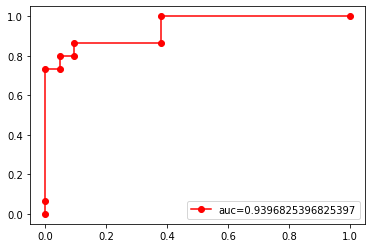

In [7]:
#Logistic Regression

model = LogisticRegression(max_iter=1000)
model.fit(xTrain,yTrain)
y_pred1 = model.predict(xTest)
y_pred_proba1 = model.predict_proba(xTest)[:,1]
#y_pred1 = clf1.predict(Test)
fpr1, tpr1, _ = metrics.roc_curve(yTest,  y_pred_proba1)
auc1 = metrics.roc_auc_score(yTest, y_pred_proba1)
print("score", model.score(xTest,yTest))
plt.plot(fpr1,tpr1,'ro-',label="auc="+str(auc1))
plt.legend(loc=4)
plt.show()

In [37]:
# Logistic Regression

L = LogisticRegression(max_iter=5000)
folds = KFold(n_splits=18)
print("Baseline",np.mean(cross_val_score(L, X, y, cv=folds)))

Baseline 0.8555555555555556


# KNN 

In [39]:
cv_scores = []
cv = KFold(n_splits=18)
n_neighbor_list = []
cv_extend_list = []

for v in range(100):
    cv_scores = []
    for i in range(1,30,1):
        knn_cv = KNeighborsClassifier(n_neighbors=i)
        #cross_val_score(L, xTest, yTest, cv=5)
        cv_scores.append(1-np.mean(cross_val_score(knn_cv, xTrain, yTrain, cv=cv)))
    #print(cv_scores)
    cv_extend_list.append(cv_scores)
np.array(cv_extend_list).shape
# n_neighbor = cv_extend_list.index([np.min(cv_extend_list)])+1
# #     if (n_neighbor) == 1:
# #         cv_scores.remove(np.min(cv_scores))
# #         n_neighbor = cv_scores.index([np.min(cv_scores)])+1
# #n_neighbor_list.append(n_neighbor)
# #print(max(set(n_neighbor_list), key=n_neighbor_list.count))
# plt.plot(np.arange(1,30,1),cv_extend_list)
# plt.xticks(np.arange(1,30))
# plt.xlabel('Number of neighbors')
# plt.ylabel('Average CV error')

(100, 29)

In [12]:
# x = np.mean(np.array(cv_extend_list), axis=0)
# plt.plot(np.arange(1,30,1),x)
# plt.xticks(np.arange(1,30))
# plt.xlabel('Number of neighbors')
# plt.ylabel('Average CV error')

In [41]:
def Knn(xTrain, yTrain, xTest, yTest):
    clf2 = KNeighborsClassifier(n_neighbor).fit(xTrain, yTrain)
    y_pred2 = clf2.predict(xTest)
    y_pred_proba2 = clf2.predict_proba(xTest)[:,1]
    fpr2, tpr2, _ = metrics.roc_curve(yTest,  y_pred_proba2)
    #print(yTest, y_pred_proba2)
    auc2 = metrics.roc_auc_score(yTest, y_pred_proba2)
    #print(clf2.score(xTest, yTest))
    plt.plot(fpr2,tpr2,'bo-',label="auc="+str(auc2))
    plt.legend(loc=4)
    plt.show()
    return auc2

In [42]:
#Pearson Correlation coefficient
newCols = []
coeffs = []
pairDict = {}
coeffDict = {}
aucdicts = {}
for p in range(0,X.shape[1]):
    for n in range(0,X.shape[1]):
        if (p != n):
            coeff = stats.pearsonr(X[:, p], X[:, n])[0]
            if ( abs(coeff) > 0.5):
                if (p not in pairDict.keys()):
                    pairDict[p] = [n]
                else:
                    pairDict[p].append(n)

In [43]:
finalCol = []
dependencyListLen = [len(pairDict[x]) for x in pairDict.keys()]
count = 0
for n in range(0,1):
    for x in pairDict.keys():
        if (max(dependencyListLen) == len(pairDict[x])):
            finalCol.extend(list(pairDict[x]))
            dependencyListLen.remove(max(dependencyListLen))
            break

In [44]:
len(finalCol)

106

In [45]:
finalCol = list(set(finalCol))
newfeatureset = set(np.arange(0,432)) - set(np.array(finalCol))
len(newfeatureset)

326

12


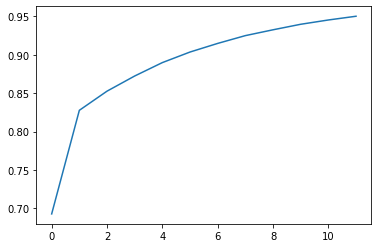

In [46]:
pca = PCA(0.95)
#XPca = pca.fit_transform(X[:, list(newfeatureset)],y)
XPca = pca.fit_transform(X[:, list(newfeatureset)],y)
#X_test = pca.fit_transform(xTest[:, finalCol])
#explained_variance = pca.explained_variance_ratio_
# pcaFinal = []
# [pcaFinal.append(i) for i,n in enumerate(list(explained_variance)) if abs(n)>0.00001]
featset = len(pca.explained_variance_ratio_.cumsum()[pca.explained_variance_ratio_.cumsum()<0.999])
print(featset)
plt.plot(np.arange(len(pca.explained_variance_ratio_.cumsum())), pca.explained_variance_ratio_.cumsum())

In [47]:
XPca.shape

(180, 12)

In [48]:
#new_train = X[:, list(newfeatureset)]
new_train = X
# new_train = XPca
# new_train = XPca[:, np.arange(0,featset)]
# print(new_train.shape)
# new_test = x[:, finalCol]
#cv = StratifiedKFold() # 
auc = []
#cv = StratifiedKFold(n_splits=18, shuffle=True)
#cv = LeaveOneOut()

ytestLi = []
ypredLi = []
accuracy = []
specout = []
sensout  = []
#xTrain, xTest, yTrain, yTest = train_test_split(new_train, y, test_size = 0.3, random_state = 0)
for train_index, test_index in cv.split(new_train):
    #print('TRAIN:', train_index, 'TEST:', test_index)
    X_train_cv, X_test_cv = new_train[train_index], new_train[test_index] # select X for training and testing
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    #print(train_index, test_index)
    #print(Knn(X_train_cv, t_train_cv, X_test_cv, t_test_cv))
    #clf2 = KNeighborsClassifier(3).fit(X_train_cv, y_train_cv)
    clf2 = LogisticRegression().fit(X_train_cv, y_train_cv)
    #y_pred_proba2 = clf2.predict_proba(X_test_cv)[:,1]
    #fpr2, tpr2, _ = metrics.roc_curve(y_test_cv,  y_pred_proba2)
#     print(yTest, y_pred_proba2)
    y_pred_proba = clf2.predict(X_test_cv)
#     print(y_pred_proba)
#     print(y_test_cv)
    #print(metrics.accuracy_score(y_test_cv, y_pred_proba))
    if(metrics.confusion_matrix(y_test_cv, y_pred_proba).ravel().shape[0] == 1):
        if y_pred_proba[0] == 1:
            tp = metrics.confusion_matrix(y_test_cv, y_pred_proba).ravel()[0]
            tn = 0
        else:
            tn = metrics.confusion_matrix(y_test_cv, y_pred_proba).ravel()[0]
            tp = 0

        fp = 0
        fn = 0

    else:
        tn, fp, fn, tp = metrics.confusion_matrix(y_test_cv, y_pred_proba).ravel()
    
    #print(tn, fp, fn, tp)
        
    if tp+fn == 0:
        sens = 0
    else:
        sens = tp/(tp+fn)

    if fp+tn == 0:
        spec = 0
    else:
        spec = tn/(fp+tn)
    print((tp+tn)/(tp+tn+fp+fn))
    
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    #aucout.append(metrics.roc_auc_score(y_test_cv, y_pred_proba))
    #fpr, tpr, _ = metrics.roc_curve(y_test_cv, y_pred_proba)
    #print(fpr)
    
    specout.append(spec)
    sensout.append(sens)
    #auc2 = metrics.roc_auc_score(y_test_cv, y_pred_proba2)
    #print(auc2)
    #auc.append(auc2)
#auc.append(auc2)

# for i in range(0, len(ytestLi)):
#     auc.append(metrics.roc_auc_score(ytestLi[i],  ypredLi[i]))
print(np.mean(accuracy))
#print(yTest.shape)
# ypred_proba = clf2.predict_proba(xTest[:, finalcol])[:, 1]
# fpr2, tpr2, _ = metrics.roc_curve(yTest,  ypred_proba)
# aucFinal = metrics.roc_auc_score(yTest, ypred_proba)
# print(aucFinal)

0.6
1.0
0.9
0.9
0.9
1.0
0.8
0.8
1.0
0.9
1.0
0.7
0.9
0.9
0.9
0.5
0.9
0.8
0.8555555555555556


In [49]:

clf2 = KNeighborsClassifier(3).fit(xTrain, yTrain)
y_pred_proba = clf2.predict(xTest)
#     print(y_pred_proba)
#     print(y_test_cv)
    #print(metrics.accuracy_score(y_test_cv, y_pred_proba))
if(metrics.confusion_matrix(yTest, y_pred_proba).ravel().shape[0] == 1):
    if y_pred_proba[0] == 1:
        tp = metrics.confusion_matrix(yTest, y_pred_proba).ravel()[0]
        tn = 0
    else:
        tn = metrics.confusion_matrix(yTest, y_pred_proba).ravel()[0]
        tp = 0

    fp = 0
    fn = 0

else:
    tn, fp, fn, tp = metrics.confusion_matrix(yTest, y_pred_proba).ravel()

#print(tn, fp, fn, tp)

if tp+fn == 0:
    sens = 0
else:
    sens = tp/(tp+fn)

if fp+tn == 0:
    spec = 0
else:
    spec = tn/(fp+tn)
#print((tp+tn)/(tp+tn+fp+fn))
print((tp+tn)/(tp+tn+fp+fn))
#aucout.append(metrics.roc_auc_score(y_test_cv, y_pred_proba))
#fpr, tpr, _ = metrics.roc_curve(y_test_cv, y_pred_proba)
#print(fpr)

specout.append(spec)
sensout.append(sens)
    #auc2 = metrics.roc_auc_score(y_test_cv, y_pred_proba2)
    #print(auc2)
    #auc.append(auc2)
#auc.append(auc2)

# for i in range(0, len(ytestLi)):
#     auc.append(metrics.roc_auc_score(ytestLi[i],  ypredLi[i]))
#print(accuracy)

0.8055555555555556


In [50]:
print(yTest.shape)
xTrain.shape 

(36,)


(144, 432)

76 29
beta_ec_28 alpha_ec_29


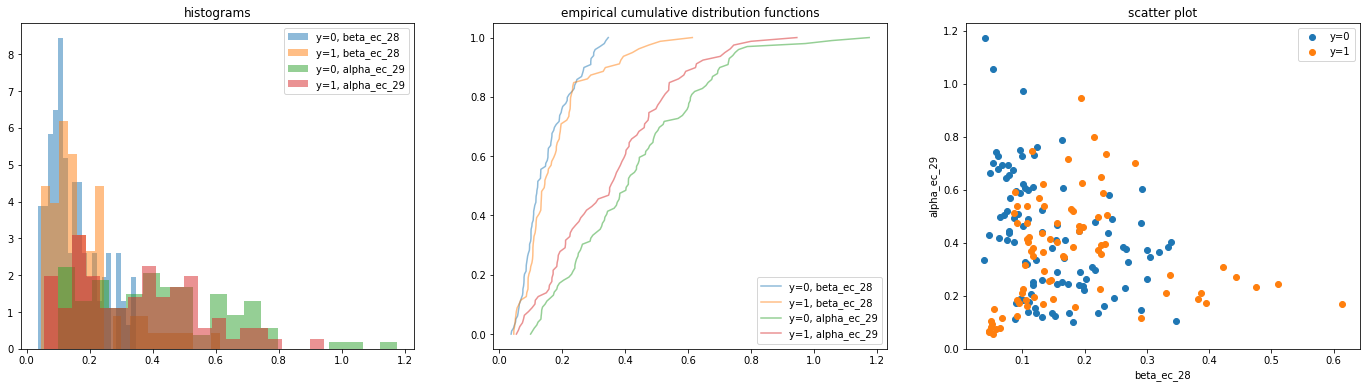

In [51]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)
print(i0, i1)
print(feature_names[i0], feature_names[i1])
# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2aaA)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()